In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import creep_event_picker as cep
import obspy
from matplotlib.dates import num2date
import matplotlib.dates as mdates
import h5py
from tqdm import tqdm  # Import tqdm for progress bar

from scipy.signal import find_peaks, savgol_filter


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import cpuinfo
print(cpuinfo.get_cpu_info()['flags'])

['acpi', 'aes', 'apic', 'clflush', 'clfsh', 'cmov', 'cx16', 'cx8', 'de', 'ds', 'dscpl', 'dtes64', 'dtse64', 'est', 'fpu', 'fxsr', 'htt', 'lahf_lm', 'mca', 'mce', 'mmx', 'mon', 'monitor', 'msr', 'mtrr', 'pae', 'pat', 'pbe', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'seglim64', 'sep', 'ss', 'sse', 'sse2', 'sse3', 'sse4.1', 'sse4.2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tpr', 'tsc', 'vme', 'vmx']


In [3]:
def check_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(path, exist_ok=True)

In [5]:
with h5py.File('../../Data/DATA_tidied/HDF5/SJN1.h5', 'r') as hdf:
    # List all groups and datasets in the file
    print("Keys: %s" % hdf.keys())
    
    # Access a specific dataset
    dataset = hdf['SJN1_1.0mins']
    slip = dataset['Slip_SJN1_1.0mins'][:]
    time =  dataset['Time_SJN1_1.0mins'][:]
    decoded_time = [byte_str.decode('utf-8') for byte_str in time]
    decoded_time = pd.to_datetime(decoded_time)
    print("Keys: %s" % dataset.keys())
    # Print the data
    print(decoded_time,slip)

Keys: <KeysViewHDF5 ['SJN1_1.0mins', 'SJN1_10.0mins', 'SJN1_30.0mins']>
Keys: <KeysViewHDF5 ['Slip_SJN1_1.0mins', 'Time_SJN1_1.0mins']>
DatetimeIndex(['2020-11-25 00:00:59', '2020-11-25 00:02:00',
               '2020-11-25 00:02:59', '2020-11-25 00:04:00',
               '2020-11-25 00:04:59', '2020-11-25 00:06:00',
               '2020-11-25 00:06:59', '2020-11-25 00:08:00',
               '2020-11-25 00:09:00', '2020-11-25 00:09:59',
               ...
               '2024-09-17 22:05:59', '2024-09-17 22:07:00',
               '2024-09-17 22:07:59', '2024-09-17 22:09:00',
               '2024-09-17 22:09:59', '2024-09-17 22:11:00',
               '2024-09-17 22:12:00', '2024-09-17 22:12:59',
               '2024-09-17 22:14:00', '2024-09-17 22:14:59'],
              dtype='datetime64[ns]', length=1430333, freq=None) [ 1.486  1.486  1.486 ... 16.897 16.897 16.897]


In [6]:
def template_function(t, n, Tau, V_0):
    return V_0*Tau*n*(1-(1+(1-1/n)*((t)/Tau))**(1/(1-n)))

In [7]:
t=np.linspace(0,60*24,60*24+1)
t

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.438e+03, 1.439e+03,
       1.440e+03])

In [8]:
template = template_function(t,1.6,30,0.01)

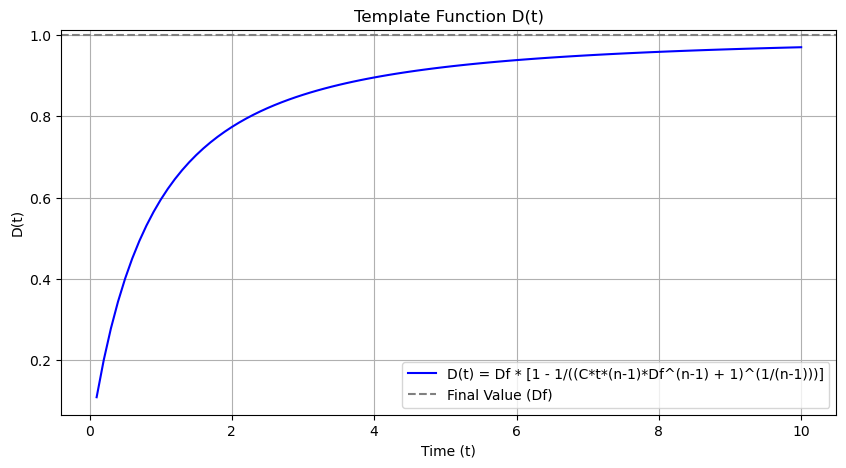

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def template_v2(t, Df, C, n):
    """Calculate the template function D(t) based on the provided formula.
    
    Args:
        t (array-like): Array of time values.
        Df (float): Final value (asymptote).
        C (float): Constant affecting the rate of change.
        n (float): Exponent parameter.
    
    Returns:
        np.ndarray: Calculated values of D(t).
    """
    # Avoid division by zero
    t = np.clip(t, a_min=1e-10, a_max=None)  # Ensure t is not zero
    denominator = C * t * (n - 1) * Df**(n - 1) + 1
    return Df * (1 - 1 / (denominator**(1 / (n - 1))))

# Example usage
t_values = np.linspace(0.1, 10, 100)  # Time values from 0.1 to 10 (avoid t=0)
Df = 1  # Example final value
C = 1.2  # Example constant
n = 1.6    # Example exponent parameter

# Calculate the template
D_values = template_v2(t_values, Df, C, n)

# Plotting the result
plt.figure(figsize=(10, 5))
plt.plot(t_values, D_values, label='D(t) = Df * [1 - 1/((C*t*(n-1)*Df^(n-1) + 1)^(1/(n-1)))]', color='blue')
plt.title('Template Function D(t)')
plt.xlabel('Time (t)')
plt.ylabel('D(t)')
plt.axhline(y=Df, color='gray', linestyle='--', label='Final Value (Df)')
plt.legend()
plt.grid()
plt.show()



In [10]:
tm_int, creep_int, upsampled = cep.interpolate(decoded_time,slip,1)


Calculating cross-correlation: 100%|██████████| 1997003/1997003 [00:44<00:00, 44816.70it/s]


107


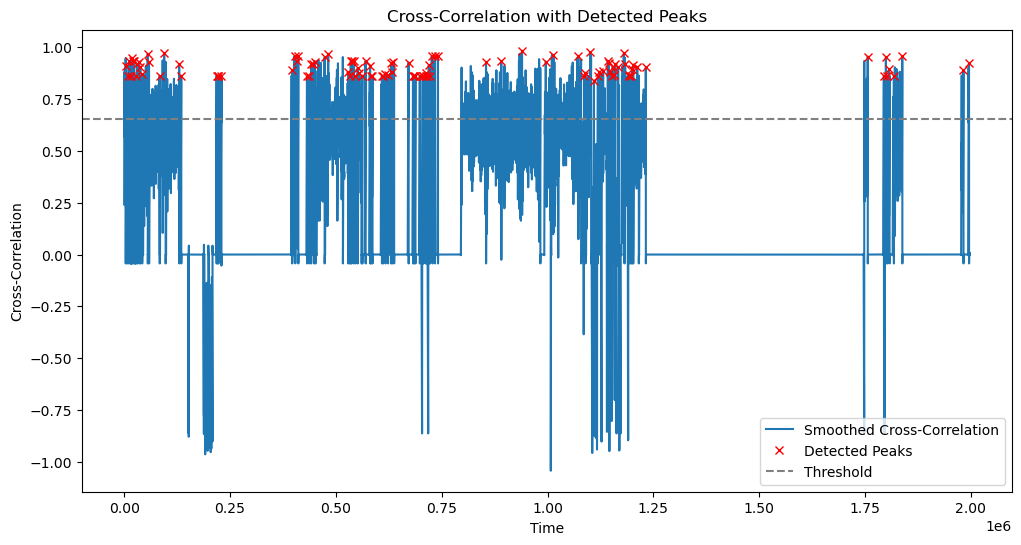

Peak Times in Original Data: ['2020-11-27T13:10:00.000000000' '2020-11-30T16:35:00.000000000'
 '2020-12-02T13:23:00.000000000' '2020-12-05T10:31:00.000000000'
 '2020-12-06T12:12:00.000000000' '2020-12-08T12:14:00.000000000'
 '2020-12-10T09:01:00.000000000' '2020-12-12T18:24:00.000000000'
 '2020-12-15T06:57:00.000000000' '2020-12-18T13:52:00.000000000'
 '2020-12-20T11:04:00.000000000' '2020-12-22T22:58:00.000000000'
 '2021-01-01T14:15:00.000000000' '2021-01-03T17:35:00.000000000'
 '2021-01-21T07:33:00.000000000' '2021-01-28T14:56:00.000000000'
 '2021-02-22T05:30:00.000000000' '2021-02-25T14:57:00.000000000'
 '2021-04-24T14:14:00.000000000' '2021-04-26T08:10:00.000000000'
 '2021-04-27T13:43:00.000000000' '2021-05-02T11:49:00.000000000'
 '2021-08-26T14:22:00.000000000' '2021-08-30T15:25:00.000000000'
 '2021-09-03T10:15:00.000000000' '2021-09-05T14:31:00.000000000'
 '2021-09-19T20:41:00.000000000' '2021-09-23T12:52:00.000000000'
 '2021-09-26T12:42:00.000000000' '2021-09-29T16:16:00.0000000

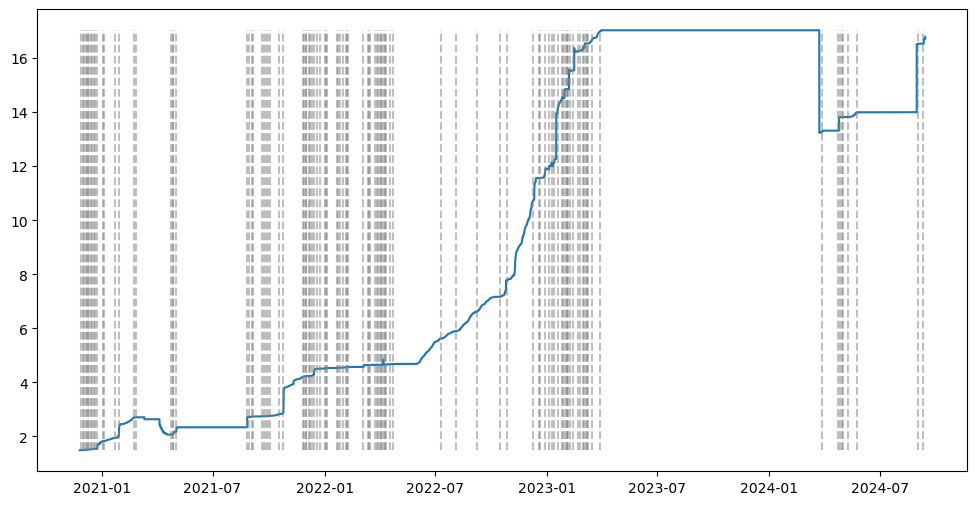

In [11]:
def compute_cross_correlation(u, v, window_length=11, polyorder=2):
    """
    Computes the cross-correlation between a template and a smoothed version of the data.

    Args:
        u (np.ndarray): The template array.
        v (np.ndarray): The data array (creep meter data).
        window_length (int): Length of the filter window for smoothing (should be odd).
        polyorder (int): Order of the polynomial used to fit the samples.

    Returns:
        np.ndarray: The cross-correlation values.
    """
    # Step 1: Smooth the original data
    v_smoothed = savgol_filter(v, window_length=window_length, polyorder=polyorder)

    n = len(u)
    v_len = len(v_smoothed)
    w_T = np.zeros(v_len - n + 1)  # Preallocate array for speed

    # Remove the mean from u for normalization
    u_mean = np.mean(u)
    u_normalized = u - u_mean

    # Iterate over the starting points of the windows in v with progress tracking
    for i in tqdm(range(v_len - n + 1), desc="Calculating cross-correlation"):
        v_window = v_smoothed[i:i + n]
        v_window_mean = np.mean(v_window)
        v_window_normalized = v_window - v_window_mean

        # Calculate the cross-correlation value using vectorized operations
        b = np.sum(u_normalized * v_window_normalized)
        d = np.sum(u_normalized ** 2)
        f = np.sum(v_window_normalized ** 2)

        if d > 0 and f > 0:  # Avoid division by zero
            w_T[i] = b / np.sqrt(d * f)
        else:
            w_T[i] = 0  # Handle the case where denominator is zero

    return w_T

# Example usage
# Assuming you have defined `template` (u) and `creep_int` (v) arrays
u = template
v = creep_int
cross_corr = compute_cross_correlation(u, v)


# Assuming cross_correlation is your noisy cross-correlation data
smoothed_cc = savgol_filter(cross_corr, window_length=51, polyorder=3)

# Set threshold for peak detection
mean_cc = np.mean(smoothed_cc)
std_cc = np.std(smoothed_cc)
threshold = mean_cc + 1.5 * std_cc  # Adjust as needed

# Find peaks
peaks, properties = find_peaks(smoothed_cc, height=threshold, prominence=0.9, distance=600,width=2)
print(len(peaks))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(smoothed_cc, label='Smoothed Cross-Correlation')
plt.plot(peaks, smoothed_cc[peaks], "x", label='Detected Peaks', color='red')
plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
plt.legend()
plt.title('Cross-Correlation with Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Cross-Correlation')
plt.show()

original_data_length = len(v)
template_length = len(u)
peak_times = peaks - (template_length - 1)  # Adjust peak indices to correspond to original data times

# Assuming you have a time array corresponding to your original data
time_array = tm_int  # Replace with actual time array if available
peak_times_in_original = time_array[peak_times]


# Output the times corresponding to the peaks
print("Peak Times in Original Data:", peak_times_in_original)


plt.figure(figsize=(12,6))
plt.plot(tm_int,creep_int,label='creep data')
plt.vlines(x=peak_times_in_original,ymin = np.min(creep_int),ymax=np.max(creep_int),colors='grey',linestyles='--',alpha=0.5)
plt.show()

Calculating cross-correlation:   0%|          | 0/1664144 [00:00<?, ?it/s]

Calculating cross-correlation: 100%|██████████| 1664144/1664144 [00:38<00:00, 43585.50it/s]


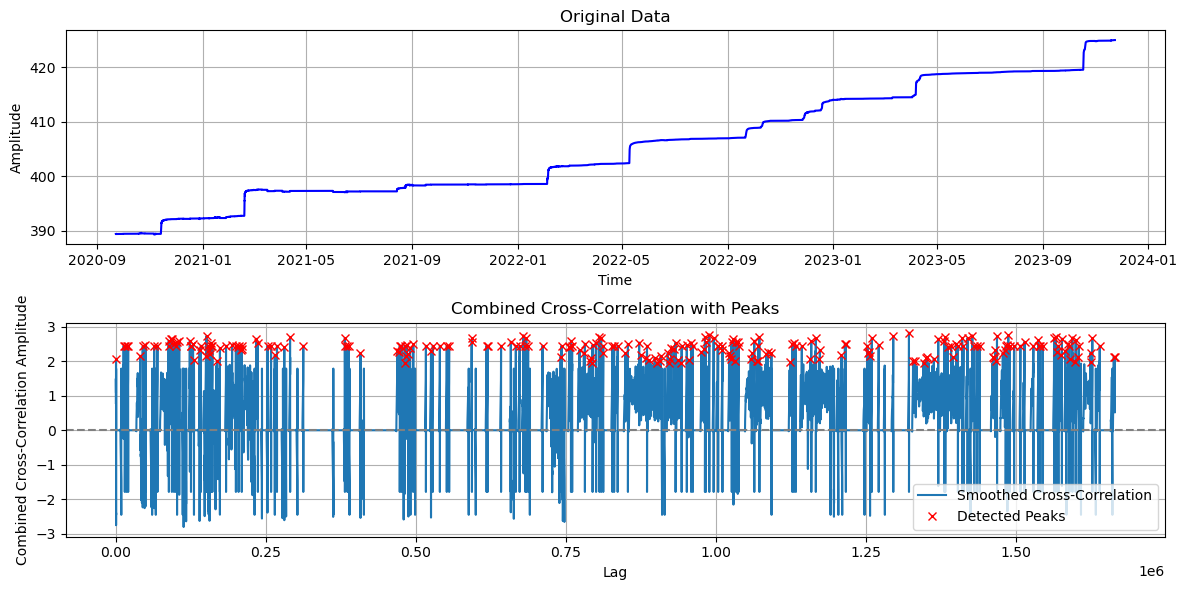

Peak Times in Original Data: ['2023-11-22T10:10:00.000000000' '2020-09-30T14:00:00.000000000'
 '2020-10-01T21:50:00.000000000' '2020-10-03T22:16:00.000000000'
 '2020-10-05T19:27:00.000000000' '2020-10-19T15:03:00.000000000'
 '2020-10-22T15:45:00.000000000' '2020-10-25T19:57:00.000000000'
 '2020-11-04T22:49:00.000000000' '2020-11-08T16:07:00.000000000'
 '2020-11-21T18:14:00.000000000' '2020-11-21T21:30:00.000000000'
 '2020-11-24T10:03:00.000000000' '2020-11-25T10:05:00.000000000'
 '2020-11-27T18:49:00.000000000' '2020-11-29T17:37:00.000000000'
 '2020-12-01T05:51:00.000000000' '2020-12-03T20:53:00.000000000'
 '2020-12-16T02:45:00.000000000' '2020-12-17T04:58:00.000000000'
 '2020-12-17T11:30:00.000000000' '2020-12-19T21:08:00.000000000'
 '2020-12-20T21:55:00.000000000' '2020-12-27T10:15:00.000000000'
 '2020-12-28T23:07:00.000000000' '2021-01-03T18:55:00.000000000'
 '2021-01-04T10:41:00.000000000' '2021-01-05T17:01:00.000000000'
 '2021-01-06T22:38:00.000000000' '2021-01-07T22:44:00.0000000

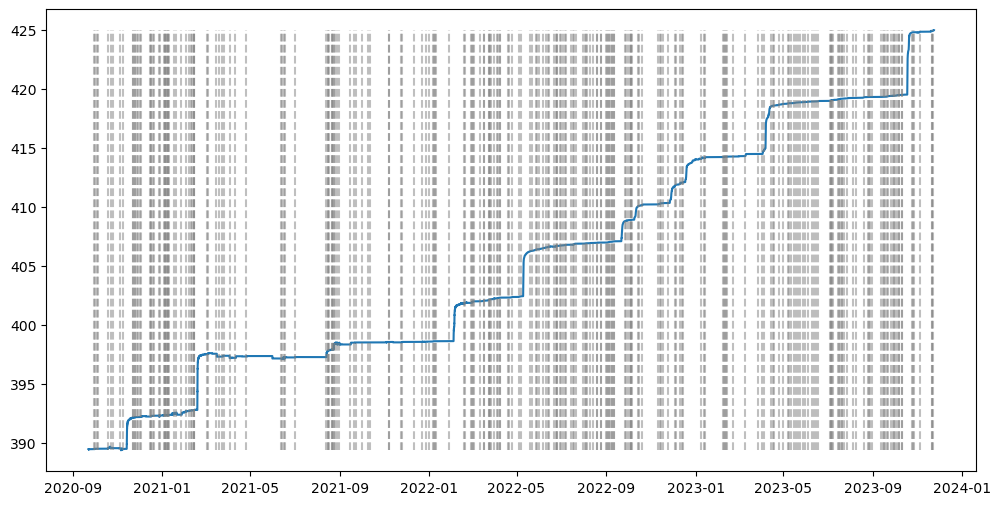

In [156]:


def template_v2(t, Df, C, n):
    t = np.clip(t, a_min=1e-10, a_max=None)
    denominator = C * t * (n - 1) * Df**(n - 1) + 1
    return Df * (1 - 1 / (denominator**(1 / (n - 1))))

# Example parameters
t_values = t
C = 0.5
n = 2
Df_values = [.25, .5, 1]  # Different Df values


v = creep_int



# Perform cross-correlation for each Df value
cross_corrs = []
for Df in Df_values:
    template = template_v2(t_values, Df, C, n)
    u = template
    cross_corr = compute_cross_correlation(u, v)
    cross_corrs.append(cross_corr)

# Combine the cross-correlation results
# combined_cross_corr = np.mean(cross_corrs, axis=0)
combined_cross_corr = np.sum(cross_corrs, axis=0)

# Assuming cross_correlation is your noisy cross-correlation data
#smoothed_cc = savgol_filter(combined_cross_corr, window_length=51, polyorder=3)
smoothed_cc = combined_cross_corr

# Set threshold for peak detection
mean_cc = np.mean(smoothed_cc)
std_cc = np.std(smoothed_cc)
threshold = mean_cc + 2.5 * std_cc  # Adjust as needed

# Find peaks
peaks, properties = find_peaks(smoothed_cc, height=threshold, prominence=0.9, distance=60,width=2)


# Plotting
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(2, 1, 1)
plt.plot(tm_int, creep_int, label='Original Data', color='blue')
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()


# Plot combined cross-correlation
plt.subplot(2, 1, 2)
plt.plot(smoothed_cc, label='Smoothed Cross-Correlation')
plt.plot(peaks, smoothed_cc[peaks], "x", label='Detected Peaks', color='red')
plt.title('Combined Cross-Correlation with Peaks')
plt.xlabel('Lag')
plt.ylabel('Combined Cross-Correlation Amplitude')
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




original_data_length = len(v)
template_length = len(u)
peak_times = peaks - (template_length - 1)  # Adjust peak indices to correspond to original data times

# Assuming you have a time array corresponding to your original data
time_array = tm_int  # Replace with actual time array if available
peak_times_in_original = time_array[peak_times]


# Output the times corresponding to the peaks
print("Peak Times in Original Data:", peak_times_in_original)
print(len(peak_times_in_original))

plt.figure(figsize=(12,6))
plt.plot(tm_int,creep_int,label='creep data')
plt.vlines(x=peak_times_in_original,ymin = np.min(creep_int),ymax=np.max(creep_int),colors='grey',linestyles='--',alpha=0.5)
plt.show()

In [9]:

plt.close('all')
for i in range(len(creepmeter_info)):
    path = "../../Data/{p}/SAC/{q}.SAC".format(p=creepmeter_info.Network.iloc[i],q =creepmeter_info.File_code.iloc[i])
    path_save = "../../Data/{p}/Picks/".format(p=creepmeter_info.Network.iloc[i])
    check_dir(path_save)
    print(path)
    st = obspy.read(path)
    tr = st[0]
    tr.interpolate(sampling_rate=tr.stats.sampling_rate)
    tm = tr.times("utcdatetime")
    creep = tr.data
    sample_rate =  round(tr.stats.delta)/60
    tm_dt = []
    for w in range(len(tm)):
        tm_new = tm[w].datetime
        tm_dt.append(tm_new)
    print('now interpolate')
    tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate,5)

    time_in_mins = int(4*10080/sample_rate)#10080
    if creepmeter_info.Gittins_and_Hawthorne_2022.iloc[i] == 'True':
        df_picks_pre_picked = pd.read_csv("../../Data/{p}/Picks/{q}_picks.csv".format(p=creepmeter_info.Network.iloc[0],q =creepmeter_info.File_code.iloc[0]),index_col=0)
        df_picks = pd.read_csv("../../Data/{p}/Picks/{q}_picks.csv".format(p=creepmeter_info.Network.iloc[0],q =creepmeter_info.File_code.iloc[i]),index_col=0)
    else:
        df_picks=pd.DataFrame(columns=['ST'])
    for k in range(round(len(tm)/time_in_mins)-1):
        fig=plt.figure()
        ax = plt.subplot(1,1,1)
        plt.plot(tm_int[k*time_in_mins:(k+1)*time_in_mins],creep_int[k*time_in_mins:(k+1)*time_in_mins]-creep_int[k*time_in_mins:(k+1)*time_in_mins][0])
        bottom,top = ax.get_ylim()
        try:
            for q in range(len(df_picks)):
                plt.plot([pd.to_datetime(df_picks.ST.iloc[q]),pd.to_datetime(df_picks.ST.iloc[q])],[bottom,top],color='orange')
        except:
            print('woo')
        ax.set_xlim([tm_int[k*time_in_mins],tm_int[(k+1)*time_in_mins]])
        ax.set_ylim([bottom,top])
        scale = 1.1
        zp = cep.ZoomPan()
        figZoom = zp.zoom_factory(ax, base_scale = scale)
        figPan = zp.pan_factory(ax)
        s = 1

        fig.set_size_inches(11,11)
        plt.show()
        pts = plt.ginput(100,timeout = -1)
        plt.close('all')
        for sublist in pts:

            df = pd.DataFrame({'ST':[sublist[0]]})
            df_picks = pd.concat([df_picks,df])
    print(len(df_picks))
    
    if len(df_picks) >0:
        for r in range(len(df_picks)):

            try:
                time_convert = mdates.num2date(df_picks.ST.iloc[r])
                s3 = pd.Series(time_convert).dt.round("1min")
                df_picks.ST.iloc[r] = s3.iloc[0].replace(tzinfo=None)   
            except TypeError:
                dummy=10
        
        df_picks['ST'] = df_picks['ST'].astype(str).str[0:19]
        df_picks.ST = pd.to_datetime(df_picks.ST)
        df_picks.sort_values(by='ST',inplace=True)
        #df_picks.reset_index(inplace=True)
        df_picks.to_csv("../../Data/{p}/Picks/{q}_picks.csv".format(p=creepmeter_info.Network.iloc[i],q =creepmeter_info.File_code.iloc[i]))

        
        plt.close('all')
        df_picks_end=pd.DataFrame(columns=['ET'])
        for j in range(len(df_picks)):
            boolarr = (tm_int>=pd.to_datetime(df_picks.ST.iloc[j]).replace(tzinfo=None)-dt.timedelta(hours=2)) \
                & (tm_int<=pd.to_datetime(df_picks.ST.iloc[j]).replace(tzinfo=None)+dt.timedelta(hours=72))
            tm_event = tm_int[boolarr]
            creep_event = creep_int[boolarr]
            
                                


            fig=plt.figure()
            ax = plt.subplot(1,1,1)
            if len(creep_event) >= 1:
                plt.plot(tm_event,creep_event-creep_event[0])
                bottom,top = ax.get_ylim()
                plt.plot([pd.to_datetime(df_picks.ST.iloc[j]),pd.to_datetime(df_picks.ST.iloc[j])],[bottom,top])
                if j < len(df_picks)-1:
                    plt.plot([pd.to_datetime(df_picks.ST.iloc[j+1]),pd.to_datetime(df_picks.ST.iloc[j+1])],[bottom,top])
                ax.set_ylim(bottom,top)   
                ax.set_xlim(tm_event[0],tm_event[-1])
                scale = 1.1
                zp = cep.ZoomPan()
                figZoom = zp.zoom_factory(ax, base_scale = scale)
                figPan = zp.pan_factory(ax)
                s = 1
                fig.set_size_inches(11,11)
                plt.title('{k}/{p}'.format(k=j+1,p=len(df_picks)))
                plt.show()
                pts = plt.ginput(1,timeout = -1)
                plt.close()
                for sublist in pts:
                    df = pd.DataFrame({'ET':[sublist[0]]})
                    df_picks_end = pd.concat([df_picks_end,df]) 
                    #print(df_picks_end)
            else:
                df = pd.DataFrame({'ET':[dt.datetime(2100,1,1,0,0,0)]})
                df_picks_end = pd.concat([df_picks_end,df])

        for r in range(len(df_picks)):
            time_convert = mdates.num2date(float(df_picks_end.ET.iloc[r]))
            s3 = pd.Series(time_convert).dt.round("1min")
            df_picks_end.ET.iloc[r] = s3.iloc[0].replace(tzinfo=None)  
        
        #df_picks_end.ET= mdates.num2date(df_picks_end.ET)
        df_picks_end.reset_index(inplace=True)
        df_picks_end.drop(columns=['index'],inplace=True)

        

        df_picks['ET'] = np.ones(len(df_picks))
        for r in range(len(df_picks)):
            df_picks.ET.iloc[r]=df_picks_end.ET.iloc[r]

        df_picks.to_csv("../../Data/{p}/Picks/{q}_picks.csv".format(p=creepmeter_info.Network.iloc[i],\
                                                                       q =creepmeter_info.File_code.iloc[i]))

../../Data/East_Anatolian_Fault/SAC/sri_0.SAC
now interpolate


/Users/dagi9522/Library/CloudStorage/OneDrive-UCB-O365/Documents/GitHub/Creep_event_detection_scripts/creep_event_picker.py:638: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = upsampled.interpolate(method='ffill') #interpolate the dataset to get a continious record evenly spaced at 10 mins
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_54612/2809728349.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_picks = pd.concat([df_picks,df])


1


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_54612/2809728349.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-02-10 20:41:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_picks.ST.iloc[r] = s3.iloc[0].replace(tzinfo=None)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_54612/2809728349.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_picks_end = pd.concat([df_picks_end,df])
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_54612/2809728349.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-02